In [11]:
import numpy as np
import h5py
import matplotlib
import torch.nn as nn
import torchvision
from torch.nn import Module
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import os


# Load .npy file using numpy
input_dir = "/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/test/z1_4_33-x01.04-y00.82_noTDS_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc.hdf5"
output_dir = "/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/test/z1_4_33-x01.04-y00.82_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc.hdf5"
label_dir = "/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/test_Z_map/z1_4_33-x01.04-y00.82.npy"

tempNoT = h5py.File(input_dir, 'r')
input_data = tempNoT['array'][:]  # Shape (batch_size, channels, height, width)

tempTDS = h5py.File(output_dir, 'r')
output_data = tempTDS['array'][:]  # Shape (batch_size, channels, height, width)

label_data = np.load(label_dir)  # Shape (batch_size, label_dim)

mask = label_data>0.1

# Convert numpy arrays to PyTorch tensors
input_tensor = torch.tensor(input_data[mask], dtype=torch.float32)
output_tensor = torch.tensor(output_data[mask], dtype=torch.float32)
label_tensor = torch.tensor(label_data[mask], dtype=torch.float32)
label_tensor.fill_(0)

# Check shapes
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Output tensor shape: {output_tensor.shape}")
print(f"Label tensor shape: {label_tensor.shape}")


Input tensor shape: torch.Size([883, 64, 64])
Output tensor shape: torch.Size([883, 64, 64])
Label tensor shape: torch.Size([883])


In [12]:
# Check shapes
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Output tensor shape: {output_tensor.shape}")
print(f"Label tensor shape: {label_tensor.shape}")

Input tensor shape: torch.Size([883, 64, 64])
Output tensor shape: torch.Size([883, 64, 64])
Label tensor shape: torch.Size([883])


In [15]:
# plt.imshow(input_tensor[5,5,:,:])

In [16]:
# plt.imshow(input_tensor[:,32,32])

In [17]:
# plt.imshow(output_tensor[:,:,32,32])

In [18]:
# plt.imshow(label_tensor>0.1)
# plt.colorbar()

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConditionalUNet(nn.Module):
    def __init__(self, img_channels=1, label_dim=1, output_channels=1):
        super(ConditionalUNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(img_channels + label_dim, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder
        self.dec3 = self.upconv_block(512 + 256, 256)
        self.dec2 = self.upconv_block(256 + 128, 128)
        self.dec1 = self.upconv_block(128 + 64, 64)

        # Final Output Layer
        self.final = nn.Conv2d(64, output_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Convolutional block with two Conv2D layers and ReLU."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        """Upsampling block with ConvTranspose2D and Conv2D."""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)
        )

    def forward(self, img, label):
        """
        Forward pass for Conditional U-Net.

        Args:
        img (Tensor): 2D diffraction pattern of shape (B, 1, 64, 64).
        label (Tensor): Integer variable of shape (B, 1).

        Returns:
        Tensor: Generated 2D diffraction pattern of shape (B, 1, 64, 64).
        """
        # Expand label to match the input image size
        label_img = label.view(-1, 1, 1, 1).expand(-1, 1, img.shape[2], img.shape[3])

        # Combine input and label
        combined_input = torch.cat([img, label_img], dim=1)

        # Encoder Path
        enc1 = self.enc1(combined_input)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc3, 2))

        # Decoder Path with Correct Interpolation
        dec3 = self.dec3(torch.cat((F.interpolate(bottleneck, size=enc3.shape[2:], mode='bilinear', align_corners=False), enc3), dim=1))
        dec2 = self.dec2(torch.cat((F.interpolate(dec3, size=enc2.shape[2:], mode='bilinear', align_corners=False), enc2), dim=1))
        dec1 = self.dec1(torch.cat((F.interpolate(dec2, size=enc1.shape[2:], mode='bilinear', align_corners=False), enc1), dim=1))

        # Final Output
        final_output = self.final(dec1)

        # Ensure Output Size Matches Target (64x64)
        final_output = F.interpolate(final_output, size=(64, 64), mode='bilinear', align_corners=False)
        return final_output


In [20]:
import torch
from torch.utils.data import DataLoader, Dataset

# Corrected Dataset Class for 3D Data
class CustomDataset(Dataset):
    def __init__(self, input_data, label_data, output_data):
        self.input_data = input_data  # Shape (N, 64, 64)
        self.label_data = label_data  # Shape (N,)
        self.output_data = output_data  # Shape (N, 64, 64)

    def __len__(self):
        return self.input_data.shape[0]

    def __getitem__(self, idx):
        # Extract image, label, and target
        image = self.input_data[idx].unsqueeze(0)    # Shape (1, 64, 64)
        label = self.label_data[idx].view(1)        # Shape (1,)
        target = self.output_data[idx].unsqueeze(0) # Shape (1, 64, 64)

        return image, label.float(), target



# # Initialize Data
# input_tensor = torch.randn(59, 59, 64, 64)   # Example input
# label_tensor = torch.randint(0, 5, (59, 59)) # Example labels (integers)
# output_tensor = torch.randn(59, 59, 64, 64)  # Example target output

# Create Dataset and DataLoader
dataset = CustomDataset(input_tensor, label_tensor, output_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


Using device: cuda


Epoch [1/50]: 100%|██████████| 89/89 [00:02<00:00, 32.64it/s, loss=3.66e-5] 


Epoch [1], Train Loss: 0.0013, Test Loss: 0.0000


Epoch [2/50]: 100%|██████████| 89/89 [00:02<00:00, 35.01it/s, loss=6.89e-6]


Epoch [2], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [3/50]: 100%|██████████| 89/89 [00:02<00:00, 35.20it/s, loss=2.85e-7]


Epoch [3], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [4/50]: 100%|██████████| 89/89 [00:02<00:00, 35.07it/s, loss=2.35e-7]


Epoch [4], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [5/50]: 100%|██████████| 89/89 [00:02<00:00, 34.91it/s, loss=1.78e-7]


Epoch [5], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [6/50]: 100%|██████████| 89/89 [00:02<00:00, 35.04it/s, loss=1.69e-7]


Epoch [6], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [7/50]: 100%|██████████| 89/89 [00:02<00:00, 34.55it/s, loss=1.32e-7]


Epoch [7], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [8/50]: 100%|██████████| 89/89 [00:02<00:00, 34.90it/s, loss=1.24e-7]


Epoch [8], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [9/50]: 100%|██████████| 89/89 [00:02<00:00, 34.78it/s, loss=1.19e-7]


Epoch [9], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [10/50]: 100%|██████████| 89/89 [00:02<00:00, 34.80it/s, loss=9.72e-8]


Epoch [10], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [11/50]: 100%|██████████| 89/89 [00:02<00:00, 34.80it/s, loss=8.29e-8]


Epoch [11], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [12/50]: 100%|██████████| 89/89 [00:02<00:00, 34.69it/s, loss=8.88e-8]


Epoch [12], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [13/50]: 100%|██████████| 89/89 [00:02<00:00, 34.61it/s, loss=8.49e-8]


Epoch [13], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [14/50]: 100%|██████████| 89/89 [00:02<00:00, 34.39it/s, loss=8.51e-8]


Epoch [14], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [15/50]: 100%|██████████| 89/89 [00:02<00:00, 34.50it/s, loss=9.02e-8]


Epoch [15], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [16/50]: 100%|██████████| 89/89 [00:02<00:00, 34.44it/s, loss=6.86e-8]


Epoch [16], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [17/50]: 100%|██████████| 89/89 [00:02<00:00, 34.55it/s, loss=7.87e-8]


Epoch [17], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [18/50]: 100%|██████████| 89/89 [00:02<00:00, 34.56it/s, loss=7.98e-8]


Epoch [18], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [19/50]: 100%|██████████| 89/89 [00:02<00:00, 34.35it/s, loss=6.56e-8]


Epoch [19], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [20/50]: 100%|██████████| 89/89 [00:02<00:00, 34.45it/s, loss=7.43e-8]


Epoch [20], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [21/50]: 100%|██████████| 89/89 [00:02<00:00, 34.22it/s, loss=7.61e-8]


Epoch [21], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [22/50]: 100%|██████████| 89/89 [00:02<00:00, 34.54it/s, loss=6.11e-8]


Epoch [22], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [23/50]: 100%|██████████| 89/89 [00:02<00:00, 34.35it/s, loss=6.07e-8]


Epoch [23], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [24/50]: 100%|██████████| 89/89 [00:02<00:00, 34.63it/s, loss=7.05e-8]


Epoch [24], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [25/50]: 100%|██████████| 89/89 [00:02<00:00, 34.65it/s, loss=7.85e-8]


Epoch [25], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [26/50]: 100%|██████████| 89/89 [00:02<00:00, 34.18it/s, loss=7.41e-8]


Epoch [26], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [27/50]: 100%|██████████| 89/89 [00:02<00:00, 34.31it/s, loss=5.85e-8]


Epoch [27], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [28/50]: 100%|██████████| 89/89 [00:02<00:00, 33.98it/s, loss=8.17e-8]


Epoch [28], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [29/50]: 100%|██████████| 89/89 [00:02<00:00, 33.70it/s, loss=5.13e-8]


Epoch [29], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [30/50]: 100%|██████████| 89/89 [00:02<00:00, 34.04it/s, loss=5.97e-8]


Epoch [30], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [31/50]: 100%|██████████| 89/89 [00:02<00:00, 34.36it/s, loss=6.41e-8]


Epoch [31], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [32/50]: 100%|██████████| 89/89 [00:02<00:00, 34.34it/s, loss=5.37e-8]


Epoch [32], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [33/50]: 100%|██████████| 89/89 [00:02<00:00, 34.25it/s, loss=6.71e-8]


Epoch [33], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [34/50]: 100%|██████████| 89/89 [00:02<00:00, 33.80it/s, loss=7.56e-8]


Epoch [34], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [35/50]: 100%|██████████| 89/89 [00:02<00:00, 33.93it/s, loss=5.16e-8]


Epoch [35], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [36/50]: 100%|██████████| 89/89 [00:02<00:00, 33.71it/s, loss=7.02e-8]


Epoch [36], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [37/50]: 100%|██████████| 89/89 [00:02<00:00, 34.11it/s, loss=6.63e-8]


Epoch [37], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [38/50]: 100%|██████████| 89/89 [00:02<00:00, 34.14it/s, loss=5.89e-8]


Epoch [38], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [39/50]: 100%|██████████| 89/89 [00:02<00:00, 33.53it/s, loss=5.41e-8]


Epoch [39], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [40/50]: 100%|██████████| 89/89 [00:02<00:00, 34.43it/s, loss=5.06e-8]


Epoch [40], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [41/50]: 100%|██████████| 89/89 [00:02<00:00, 34.19it/s, loss=6.18e-8]


Epoch [41], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [42/50]: 100%|██████████| 89/89 [00:02<00:00, 34.06it/s, loss=6.76e-8]


Epoch [42], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [43/50]: 100%|██████████| 89/89 [00:02<00:00, 33.89it/s, loss=6.43e-8]


Epoch [43], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [44/50]: 100%|██████████| 89/89 [00:02<00:00, 34.12it/s, loss=6.07e-8]


Epoch [44], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [45/50]: 100%|██████████| 89/89 [00:02<00:00, 34.21it/s, loss=5.17e-8]


Epoch [45], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [46/50]: 100%|██████████| 89/89 [00:02<00:00, 33.62it/s, loss=5.13e-8]


Epoch [46], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [47/50]: 100%|██████████| 89/89 [00:02<00:00, 34.24it/s, loss=1.6e-7] 


Epoch [47], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [48/50]: 100%|██████████| 89/89 [00:02<00:00, 34.22it/s, loss=6.06e-8]


Epoch [48], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [49/50]: 100%|██████████| 89/89 [00:02<00:00, 34.15it/s, loss=4.79e-8]


Epoch [49], Train Loss: 0.0000, Test Loss: 0.0000


Epoch [50/50]: 100%|██████████| 89/89 [00:02<00:00, 33.87it/s, loss=5.16e-8]


Epoch [50], Train Loss: 0.0000, Test Loss: 0.0000


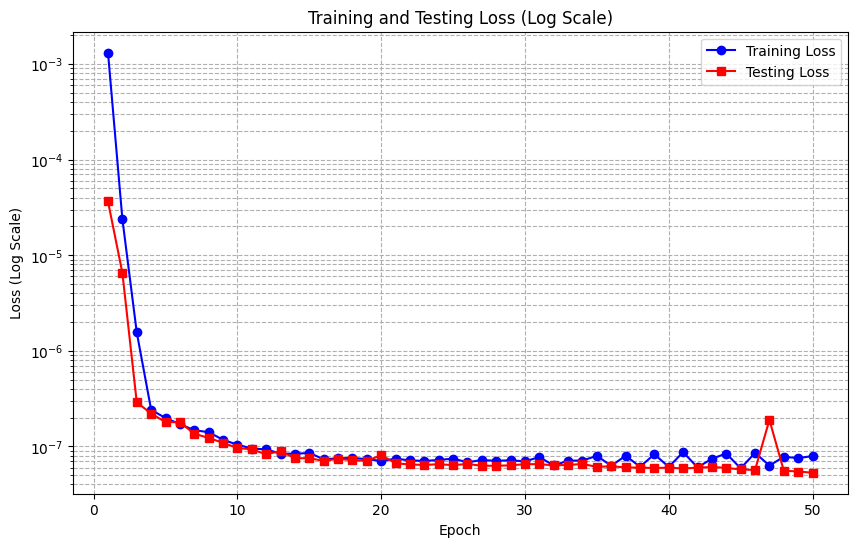

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Model, Loss, and Optimizer
model = ConditionalUNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Split Dataset into Training and Testing Sets (80:20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Track Training and Testing Loss
train_losses = []
test_losses = []

# Training Loop
num_epochs = 50
# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    
    # Training Loop with Progress Bar
    loop = tqdm(train_loader, total=len(train_loader), leave=True)
    for image, label, target in loop:
        # Move data to GPU
        image, label, target = image.to(device), label.to(device), target.to(device)

        optimizer.zero_grad()

        # Forward pass
        prediction = model(image, label)

        # Calculate Loss and Backpropagation
        loss = criterion(prediction, target)
        loss.backward()
        optimizer.step()

        # Update Progress Bar
        running_train_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Average Training Loss
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on Test Set
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for image, label, target in test_loader:
            image, label, target = image.to(device), label.to(device), target.to(device)
            prediction = model(image, label)

            # Calculate Test Loss
            test_loss = criterion(prediction, target)
            running_test_loss += test_loss.item()

    # Average Test Loss
    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Epoch [{epoch+1}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


# Plot Training and Testing Loss Curves with Log Scale
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o', color='b')
plt.plot(range(1, num_epochs+1), test_losses, label='Testing Loss', marker='s', color='r')

plt.title("Training and Testing Loss (Log Scale)")
plt.xlabel("Epoch")
plt.ylabel("Loss (Log Scale)")
plt.yscale('log')  # Apply log scale to y-axis
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()



/tmp/ipykernel_510856/2397801689.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_label = torch.tensor(label_tensor[idx], dtype=torch.float32, device=device).view(1, 1)  # Shape: (1, 1)


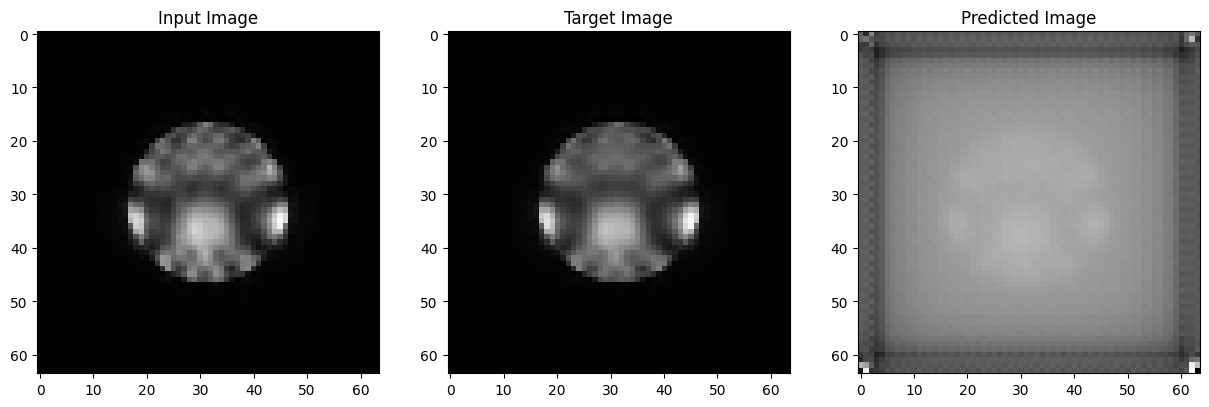

In [30]:
# Switch model to evaluation mode
model.eval()

# Select specific input sample (Use single index)
idx = 5  # Index in the reduced 3D dataset

# Extract corresponding input, label, and target
sample_input = input_tensor[idx].unsqueeze(0).unsqueeze(0).to(device)  # Shape: (1, 1, 64, 64)
sample_label = torch.tensor(label_tensor[idx], dtype=torch.float32, device=device).view(1, 1)  # Shape: (1, 1)

# Make a prediction
with torch.no_grad():
    prediction = model(sample_input, sample_label)
    pred_img = prediction.squeeze().cpu().numpy()

# Plot the images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Original Input
ax[0].imshow(sample_input.squeeze().cpu().numpy(), cmap='gray')
ax[0].set_title("Input Image")

# Ground Truth (Assuming output_tensor is available)
target_img = output_tensor[idx].cpu().numpy()
ax[1].imshow(target_img, cmap='gray')
ax[1].set_title("Target Image")

# Predicted Output
ax[2].imshow(pred_img, cmap='gray')
ax[2].set_title("Predicted Image")
# fig.colorbar()

plt.show()
